In [1]:
import numpy as np
import pandas as pd

from scipy.stats import trim_mean   # conda install scipy
from statsmodels import robust      # conda install -c conda-forge statsmodels 
import wquantiles                   # pip install wquantiles

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from random import randint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df_city = pd.read_csv('../../data/diamonds_city_202208201409.csv')
df_clarity = pd.read_csv('../../data/diamonds_clarity_202208201409.csv')
df_color = pd.read_csv('../../data/diamonds_color_202208201409.csv')
df_cut = pd.read_csv('../../data/diamonds_cut_202208201409.csv')
df_dimensions = pd.read_csv('../../data/diamonds_dimensions_202208201409.csv')
df_properties = pd.read_csv('../../data/diamonds_properties_202208201409.csv')
df_transactional = pd.read_csv('../../data/diamonds_transactional_202208201409.csv')
df_diamonds = df_properties.merge(
    df_clarity, on="clarity_id", how="left").merge(
    df_color, on="color_id", how="left").merge(
    df_cut, on="cut_id", how="left").merge(
    df_dimensions, on="index_id", how="left").merge(
    df_transactional, on="index_id", how="left").merge(df_city, on="city_id", how="left")
df_diamonds["price"] = df_diamonds["price"].astype(float)
#df_diamonds.info()

In [3]:
#reordenamos el orden de las columnas
df_diamonds = df_diamonds[['carat','depth','table','x', 'y', 'z', 'city', 'cut', 'color','clarity', 'price']]
df_diamonds_features = df_diamonds[['carat','depth','table','x', 'y', 'z', 'city', 'cut', 'color','clarity']]
df_diamonds_price = df_diamonds['price']

In [4]:
# Divide the diamond carats by 0.4 to limit the number of carat categories
# Round up to have discrete categories
df_diamonds["carat_cat"] = np.ceil(df_diamonds["carat"] / 0.35)

# Merge categories > 5 in 5
df_diamonds["carat_cat"].where(df_diamonds["carat_cat"] < 5, 5.0, inplace = True)

In [5]:
#df_diamonds

In [6]:
# Run the split. Creates on split and shares 20% of the dataset for the test set
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# Separate the stratified train set and the test set
for train_index, test_index in split.split(df_diamonds, df_diamonds["carat_cat"]):
    strat_train_set = df_diamonds.loc[train_index]
    strat_test_set = df_diamonds.loc[test_index]

In [7]:
# We now have our Train set and Test set, both stratified. From here, 
# we don't need the carat_cat anylonger, hence we can drop it.
for set in (strat_train_set, strat_test_set):
    set.drop(["carat_cat"], axis = 1, inplace = True)

# Data visualization

In [ ]:
sns.pairplot(diamonds[["price", "carat", "cut"]], hue = "cut", height = 5)
plt.show()
sns.barplot(x = "carat", y = "cut", data = diamonds)
plt.show()
sns.barplot(x = "price", y = "cut", data = diamonds)
plt.show()

In [8]:
# Do not stratify the label
diamonds = strat_train_set.drop("price", axis = 1)

# Set a new dataset label variable
diamond_labels = strat_train_set["price"].copy()

# Drop all the category, so we could have only numeric
diamonds_num = diamonds.drop(["cut", "color", "clarity", 'city'], axis = 1)
diamonds_num.head()

,carat,depth,table,x,y,z
3437,1.01,60.7,61.0,6.42,6.46,3.91
10093,1.50,62.0,61.0,7.37,7.24,4.53
29292,0.71,60.5,58.0,5.75,5.72,3.47
20717,0.44,61.9,59.0,4.90,4.86,3.02
6585,1.14,62.0,55.0,6.71,6.72,4.16


In [10]:
# Perform the feature scaling on the numeric attributes of the dataset
num_scaler = StandardScaler()
diamonds_num_scaled = num_scaler.fit_transform(diamonds_num)

# Preview 
pd.DataFrame(diamonds_num_scaled, columns=list(diamonds_num)).head()

,carat,depth,table,x,y,z
0,0.447780,-0.737495,1.593076,0.615143,0.630705,0.535454
1,1.479997,0.172517,1.593076,1.460763,1.307112,1.425517
2,-0.184189,-0.877497,0.250828,0.018759,-0.011015,-0.096204
3,-0.752962,0.102516,0.698244,-0.737848,-0.756797,-0.742218
4,0.721634,0.172517,-1.091420,0.873280,0.856174,0.894350


# Categorical

In [12]:
# We need only the category attributes to work with here
diamonds_cat = diamonds[["cut", "color", "clarity"]]
diamonds_cat.head()

,cut,color,clarity
3437,Very Good,G,VS2
10093,Premium,J,VS1
29292,Premium,F,VS1
20717,Premium,D,SI1
6585,Ideal,H,VS2


In [13]:
# Perform the one-hot encoding on the category attributes of the dataset
cat_encoder = OneHotEncoder()
diamonds_cat_encoded = cat_encoder.fit_transform(diamonds_cat)

# Convert the encoded categories to arrays and Preview
pd.DataFrame(diamonds_cat_encoded.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
# We have our tables reformed, what we do now to to merge the numeric feature scaled attributes and the encoded category 
# attributes. An easy way to do this without writing so much like above is to Scikit-Learn's ColumnTransformer class. 
# This merging provides a single pipeline for the whole dataset.
from sklearn.compose import ColumnTransformer

num_attribs = list(diamonds_num)
cat_attribs = ["cut", "color", "clarity"]

# Pipeline to transform our dataset
pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs), # Perform feaured scaling on numeric attributes
    ("cat", OneHotEncoder(), cat_attribs) # Perform One-Hot encoding on the category attributes
])

In [15]:
# Transformed dataset to feed the ML Algorithm
diamonds_ready = pipeline.fit_transform(diamonds)

# Preview
X_train = pd.DataFrame(diamonds_ready)
X_train

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.447780,-0.737495,1.593076,0.615143,0.630705,0.535454,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.479997,0.172517,1.593076,1.460763,1.307112,1.425517,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.184189,-0.877497,0.250828,0.018759,-0.011015,-0.096204,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.752962,0.102516,0.698244,-0.737848,-0.756797,-0.742218,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.721634,0.172517,-1.091420,0.873280,0.856174,0.894350,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32359,-0.163123,-1.787508,2.487908,0.036561,0.110392,-0.139271,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32360,-1.111078,0.312519,-0.644004,-1.405443,-1.346485,-1.359519,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32361,-0.984684,0.102516,-0.196588,-1.165109,-1.095000,-1.129826,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32362,1.479997,-1.437504,-0.644004,1.505269,1.497894,1.296314,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
# Remove label from test set
X_test = strat_test_set.drop("price", axis = 1)
# Have label stand alone
y_test = strat_test_set["price"].copy()

# Our models performance holder
models_rmse = [] # Holds Models original RMSE
cvs_rmse_mean = [] # Holds the Cross Validation RMSE Mean
tests_rmse = [] # Holds the tests RMSE
tests_accuracy = [] # Holds the tests accuracy
models = [] # Holds the models name

def display_model_performance(model_name, model, diamonds = diamonds_ready, labels = diamond_labels,
                              models_rmse = models_rmse, cvs_rmse_mean = cvs_rmse_mean, tests_rmse = tests_rmse,
                              tests_accuracy = tests_accuracy, pipeline = pipeline, X_test = X_test,
                              y_test = y_test, cv = True):
    # Fit dataset in model
    model.fit(diamonds, labels)
    
    # Setup predictions
    predictions = model.predict(diamonds)
    
    # Get models performance
    model_mse = mean_squared_error(labels, predictions)
    model_rmse = np.sqrt(model_mse)
    # Cross validation
    cv_score = cross_val_score(model, diamonds, labels, scoring = "neg_mean_squared_error", cv = 10)
    cv_rmse = np.sqrt(-cv_score)
    cv_rmse_mean = cv_rmse.mean()
    
    print("RMSE: %.4f" %model_rmse)
    models_rmse.append(model_rmse)
    
    print("CV-RMSE: %.4f" %cv_rmse_mean)
    cvs_rmse_mean.append(cv_rmse_mean)
    
    print("--- Test Performance ---")
    
    X_test_prepared = pipeline.transform(X_test)
    
    # Fit test dataset in model
    model.fit(X_test_prepared, y_test)
    
    # Setup test predictions
    test_predictions = model.predict(X_test_prepared)
    
    # Get models performance on test
    test_model_mse = mean_squared_error(y_test, test_predictions)
    test_model_rmse = np.sqrt(test_model_mse)
    print("RMSE: %.4f" %test_model_rmse)
    tests_rmse.append(test_model_rmse)
     # Tests accuracy
    test_accuracy = round(model.score(X_test_prepared, y_test) * 100, 2)
    print("Accuracy:", str(test_accuracy)+"%")
    tests_accuracy.append(test_accuracy)
    
    # Check how well model works on Test set by comparing prices
    start = randint(1, len(y_test))
    some_data = X_test.iloc[start:start + 7]
    some_labels = y_test.iloc[start:start + 7]
    some_data_prepared = pipeline.transform(some_data)
    print("Predictions:\t", model.predict(some_data_prepared))
    print("Labels:\t\t", list(some_labels))
    
    models.append(model_name)
    
    # Preview plot
    plt.scatter(diamond_labels, model.predict(diamonds_ready))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    plt.plot(x_lim, y_lim, "k--")
    plt.show()
    
    print("------- Test -------")
    plt.scatter(y_test, model.predict(X_test_prepared))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.plot(x_lim, y_lim, "k--")
    plt.show()

In [ ]:
regressor = RandomForestRegressor()
hyperparameters = regressor.get_params()
regressor.fit(X_test, y_test)
y_pred = regressor.predict(x_test_mix_stand)
rmse = mean_squared_error(y_pred,  y_test_mix_stand, squared=False)
rmse

C:\Users\Usuario\.conda\envs\sklearn_env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Usuario\.conda\envs\sklearn_env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

RMSE: 1127.7592
CV-RMSE: 1131.3131
--- Test Performance ---
RMSE: 1110.2514
Accuracy: 92.11%
Predictions:	 [4388.31738128 6403.53129628 9363.3032062  3946.83296664 5550.40191443
 1803.29775441 2487.55102366]
Labels:		 [4744.0, 6368.0, 9898.0, 4011.0, 5396.0, 1269.0, 2647.0]


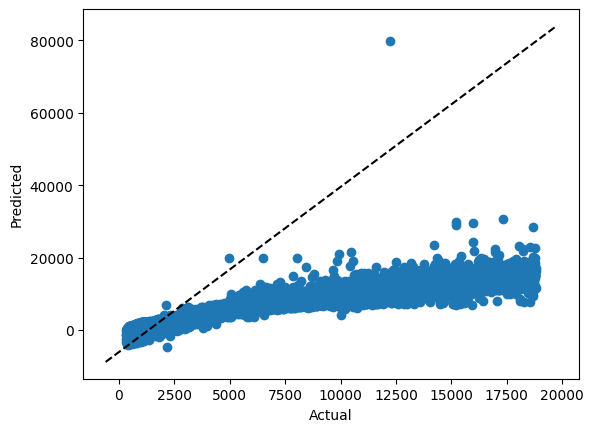

------- Test -------


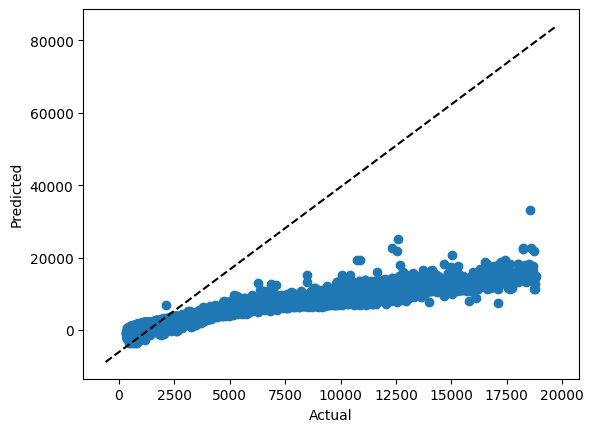

In [17]:
# Linear Regression
lin_reg = LinearRegression(normalize = True)
display_model_performance("Linear Regression", lin_reg)

RMSE: 244.8709
CV-RMSE: 584.3211
--- Test Performance ---
RMSE: 283.7898
Accuracy: 99.48%
Predictions:	 [ 1593.4 17990.7   892.1   393.9   977.5  1104.7   664.6]
Labels:		 [1563.0, 18692.0, 895.0, 404.0, 1002.0, 1114.0, 680.0]


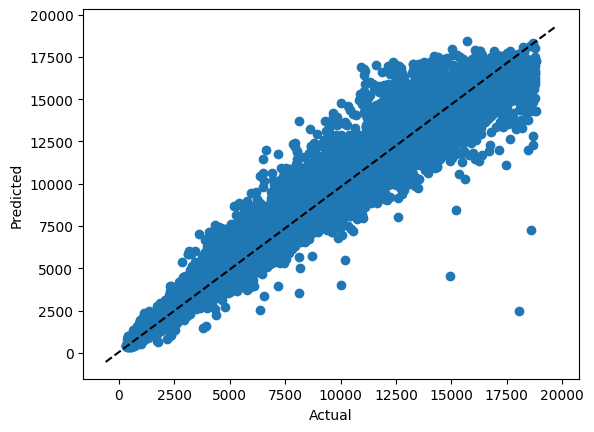

------- Test -------


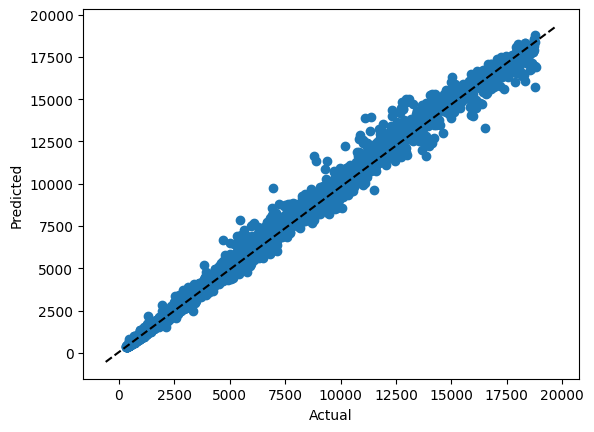

In [18]:
# Random Forest Regression

forest_reg = RandomForestRegressor(n_estimators = 10, random_state = 42)
display_model_performance("Random Forest Regression", forest_reg)

In [ ]:
regressor = RandomForestRegressor()
hyperparameters = regressor.get_params()
regressor.fit(diamonds_ready, diamond_labels)
y_pred = regressor.predict(x_test_mix_stand)
rmse = mean_squared_error(y_pred,  y_test_mix_stand, squared=False)
rmse

# Test

In [20]:
df_test = pd.read_csv('../../data/diamonds_test.csv')
df_test.drop('id', axis=1, inplace=True)
df_test.drop('city', axis=1, inplace=True)
df_test

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67
1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18
2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57
3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90
4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19
...,...,...,...,...,...,...,...,...,...
13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30
13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56
13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53
13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45


In [21]:
X_tt_prepared = pipeline.transform(df_test)
X_tt_prepared

array([[-0.01566385,  0.66252345,  1.14565951, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84802772, -0.52749203, -0.19658848, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.6274567 ,  0.31251889,  1.59307551, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.20525468, -0.10748657, -1.09142048, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20525468, -2.06751205, -0.19658848, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83722412,  0.45252071, -1.09142048, ...,  0.        ,
         0.        ,  1.        ]])

In [23]:
model_2 = RandomForestRegressor(n_estimators = 10, random_state = 42)
model_2.fit(diamonds_ready, diamond_labels)
tt_predictions = model_2.predict(X_tt_prepared)

In [25]:
solucion = pd.DataFrame(tt_predictions, columns = ['Price'])
solucion.index.names = ['id']
solucion

,Price
id,
0,2879.7
1,5221.7
2,9098.3
3,4114.9
4,1726.4
...,...
13480,1624.6
13481,2249.3
13482,2929.6


In [26]:
solucion.to_csv('../../data/results.csv')